# Setup

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

import pandas as pd
import geopandas as gpd

import sys
sys.path.append("../src")

import usa_data_Tij as USA_data
import indices
from parameters import params_default
#del sys.modules['dynamics']
from dynamics import Dynamics

In [3]:
import dynamics
import policy
import importlib
importlib.reload(policy)
importlib.reload(dynamics)
from dynamics import Dynamics

In [4]:
import importlib
#importlib.reload(USdata)

In [5]:
#T0_total, counties_pop, counties_in_state, states_in_division = USA_data.compute_Tij_from_data()

In [6]:
(census, counties_census, states_census, commuting, counties_FIPS, states_FIPS, divisions_FIPS, countyFIPS_to_index,
statesFIPS_to_index, divisionsFIPS_to_index, index_to_countyFIPS, index_to_statesFIPS, index_to_divisionsFIPS,
USstates, USdivisions, counties_pop, states_pop, divisions_pop, counties_in_state, states_in_division,
n_counties, commuting_matrix, citytocounty, faatravel, airport_enplane, Ftravelers_matrix, mod_airport_enplane,
mod_airport_arrivals, mobility_matrix, counties_realpop, frac_mobilers, frac_pop, T0_total) = USA_data.compute_Tij_from_data(output='all')

/Users/asierpini40/Documents/Projects/NECSI_EpidemicModeling/Code/notebooks/../src/usa_data_Tij.py:280: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  commuting['Index FIPS residency'] = commuting['FIPS residency'].replace(countyFIPS_to_index)  # inplace=True
/Users/asierpini40/Documents/Projects/NECSI_EpidemicModeling/Code/notebooks/../src/usa_data_Tij.py:281: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  commuting['Index FIPS work'] = commuting['FIPS work'].replace(countyFIPS_to_index)   # inplace=True
/Users/asierpini40/Document

In [7]:
N, Ntots = indices.set_N_arrays (counties_pop, counties_in_state, states_in_division)
ichild = indices.set_ichild_arrays(N, Ntots, counties_in_state, states_in_division)
iparent = indices.set_iparent_arrays (N, Ntots, ichild)

# Output folders

In [8]:
outputfolder='../plots/fig4_policies'
outputfolder_data='../data/figure_data/fig4_policies'

## Generate data of cost vs effectiveness

**NOTE: Skip this if data already generated.**

### Simulations

In [518]:
params = params_default.copy()
params['Nt'] = 1000
params['seed'] = 10

params['distrib'] = 'neg_binomial'
params['sspread'] = 2
params['beta'] = 2

#params['random_seed'] = 232323                 # Will be set below
#params['PolicyChoice'] = ...                   # Will be set below
#params['mpol1'] = ...                             # Will be set below
#params['mpol2'] = ...                             # Will be set below

params['GtoRthreshold'] = 10
params['reductionLocal'] = 2.2
params['reductionTravel'] = 10
params_cost = params.copy()

seed_base = 232323
offset = 0          # Offset seed of random number generator

iters = 20
#vals_noise = np.array([0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4])
#vals_noise = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
vals_noise = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
vals_policy = ['1scale','1scale','1scale','2scales']
vals_mpol1 = np.array([4,1,2,1])
vals_mpol2 = np.array([4,4,4,2])

# vals_noise = np.array([0.01,0.05])
# vals_policy = ['1scale','2scales']
# vals_mpol1 = np.array([1,1])
# vals_mpol2 = np.array([4,2])

final_cost = np.zeros((iters, len(vals_noise), len(vals_policy)))
final_NI = np.zeros((iters, len(vals_noise), len(vals_policy)))
avfinal_cost = np.zeros((len(vals_noise), len(vals_policy)))
avfinal_NI = np.zeros((len(vals_noise), len(vals_policy)))



Run simulations.

In [519]:
init_cut = 20   # Ignore beginning of time evolution for computation of steady state.

for nn in range(len(vals_noise)):
    params['noise'] = vals_noise[nn]

    for pp in range(len(vals_policy)):
        params['PolicyChoice'] = vals_policy[pp]
        params['mpol1'] = vals_mpol1[pp]
        params['mpol2'] = vals_mpol2[pp]
    
        print("delta = ", params['noise'], "\t policy = ", params['PolicyChoice'], "\t mpol1 = ", params['mpol1'], "\t mpol2 = ", params['mpol2'])

        for ii in range(iters):
            
            print(ii)

            params['random_seed'] = seed_base + ii + offset

            system = Dynamics(N, Ntots, ichild, iparent, T0_total, **params)
            system.compute_dynamics()

            final_cost[ii,nn,pp] = (system.obs.peopleT[-1] - system.obs.peopleT[init_cut]) / (params['Nt'] - init_cut)
            final_NI[ii,nn,pp] = np.sum(system.obs.NItot[init_cut:]) / (params['Nt'] - init_cut)

avfinal_cost = np.sum(final_cost, axis=0)/iters
avfinal_NI = np.sum(final_NI, axis=0)/iters

varfinal_cost = np.sqrt(np.sum((final_cost-avfinal_cost)**2, axis=0)/iters)
varfinal_NI = np.sqrt(np.sum((final_NI-avfinal_NI)**2, axis=0)/iters)
    

delta =  0.01 	 policy =  1scale 	 mpol1 =  4 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.01 	 policy =  1scale 	 mpol1 =  1 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.01 	 policy =  1scale 	 mpol1 =  2 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.01 	 policy =  2scales 	 mpol1 =  1 	 mpol2 =  2
0
1
2
3
4
5
6
7
8
9
delta =  0.05 	 policy =  1scale 	 mpol1 =  4 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.05 	 policy =  1scale 	 mpol1 =  1 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.05 	 policy =  1scale 	 mpol1 =  2 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.05 	 policy =  2scales 	 mpol1 =  1 	 mpol2 =  2
0
1
2
3
4
5
6
7
8
9
delta =  0.1 	 policy =  1scale 	 mpol1 =  4 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.1 	 policy =  1scale 	 mpol1 =  1 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.1 	 policy =  1scale 	 mpol1 =  2 	 mpol2 =  4
0
1
2
3
4
5
6
7
8
9
delta =  0.1 	 policy =  2scales 	 mpol1 =  1 	 mpol2 =  2
0
1
2
3
4
5
6
7
8
9
delta =  0.15 	 policy =  1scale 	 mpol1 =  4 	 mpol2

### Store data

In [394]:
#import os
#print(os.getcwd())
#os.chdir("/Users/asierpini40/Documents/Projects/NECSI_EpidemicModeling/Code/notebooks")

/Users/asierpini40/Documents/Projects/NECSI_EpidemicModeling/Code/notebooks


Change `export_data` and `import_data` to `True` to export/import simulation data.

In [520]:
export_data = False
import_data = False
filename = 'cost'
append = '_beta%g_ss%g_hGtoR%i_rL%g_rT%g_mpolX_Nt%i'%(params_cost['beta'], params_cost['sspread'],
    params_cost['GtoRthreshold'], params_cost['reductionLocal'], params_cost['reductionTravel'],
    params_cost['Nt'])

if export_data:
    
    comments = "# 2D array, first index is level of noise, second index is mpol.\n"
    comments += f"# Values of noise: {vals_noise}"
    comments += f"# Values of policy: {vals_policy}"
    comments += f"# Values of mpol1: {vals_mpol1}"
    comments += f"# Values of mpol2: {vals_mpol2}"
    
    for i in range(iters):

        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'NI_',filename,append,i+offset)
        np.savetxt(fname, final_NI[i], delimiter='\t', header=comments, comments='')
        
        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'cost_',filename,append,i+offset)
        np.savetxt(fname, final_cost[i], delimiter='\t', header=comments, comments='')
    
if import_data:
    
    for i in range(iters):

        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'NI_',filename,append,i+offset)
        final_NI[i] = np.loadtxt(fname, comments='#')
        
        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'cost_',filename,append,i+offset)
        final_cost[i] = np.loadtxt(fname, comments='#')

    avfinal_cost = np.sum(final_cost, axis=0)/iters
    avfinal_NI = np.sum(final_NI, axis=0)/iters

    varfinal_cost = np.sqrt(np.sum((final_cost-avfinal_cost)**2, axis=0)/iters)
    varfinal_NI = np.sqrt(np.sum((final_NI-avfinal_NI)**2, axis=0)/iters)

### Plot data

Change `export_file` to `True` to export figure.

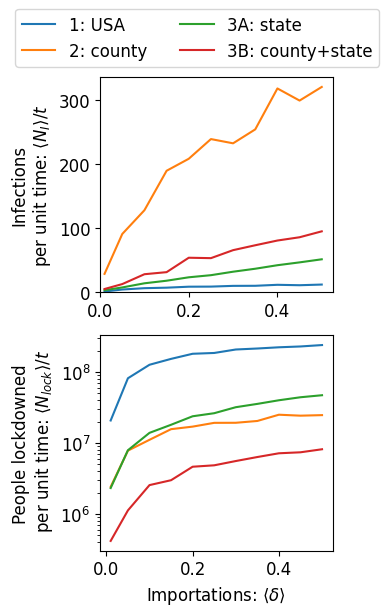

In [521]:
export_file = False
filename = 'cost'+append

figsize = [3,6]
colormap = 'tab10'  #'jet'
n_lines = len(vals_policy)

labels = ['1: USA', '2: county', '3A: state', '3B: county+state']

#cmap = mpl.colormaps.get_cmap(colormap).copy()
#cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, n_lines)))  # Set number of colors
cmap = mpl.colormaps.get_cmap(colormap)  #mpl.colormaps.get_cmap(obj)

# Set the figure size and adjust layout
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

# Update default font size and line width
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1.5})

# Plot
for hh in range(n_lines):
    
    axs[0].plot(vals_noise, avfinal_NI[:,hh], color=cmap(hh),
                label=labels[hh])
    
#axs[0].plot(vals_noise, vals_noise, '--', color='k', label='linear')

#axs[0].set_xscale('log')
#axs[0].set_yscale('log')
#axs[0].set_xlabel('Importations: '+r'$\langle \delta \rangle$')
axs[0].set_ylabel('Infections\nper unit time: ' + r'$\langle N_I \rangle/t$')
axs[0].legend(loc='center left', bbox_to_anchor=(-0.4,1.18), ncol=2)
axs[0].set_xlim(left=0)
axs[0].set_ylim(bottom=0)

# Plot
for hh in range(n_lines):
    
    axs[1].plot(vals_noise, avfinal_cost[:,hh], color=cmap(hh),
                label=labels[hh])
    
#axs[1].plot(vals_noise, vals_noise*10**6, '--', color='k', label='linear')

#axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Importations: '+r'$\langle \delta \rangle$')
axs[1].set_ylabel('People lockdowned\n per unit time: ' + r'$\langle N_{lock} \rangle/t$')
#axs[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

plt.subplots_adjust(top=0.9, wspace=0.4)   # For top bar
    
if export_file:
    plt.savefig(fname='%s/%s.pdf'%(outputfolder,filename), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

## Paper Figure

Change `export_file` to `True` to export figures.

### 3A state best

Run the following cell to import data files for the given simulation parameters.

In [9]:
# Import
params_import = params_default.copy()
params_import['Nt'] = 1000
params_import['beta'] = 2
params_import['sspread'] = 2
params_import['GtoRthreshold'] = 20     # 5 // 10 // 20 // 20
params_import['reductionLocal'] = 5     # 5 // 2  // 5  // 4
params_import['reductionTravel'] = 5    # 5 // 10 // 5 // 10

iters_import = 10

vals_noise = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
vals_policy = ['1scale','1scale','1scale','2scales']
vals_mpol1 = np.array([4,1,2,1])
vals_mpol2 = np.array([4,4,4,2])

final_cost = np.zeros((iters_import, len(vals_noise), len(vals_policy)))
final_NI = np.zeros((iters_import, len(vals_noise), len(vals_policy)))
avfinal_cost = np.zeros((len(vals_noise), len(vals_policy)))
avfinal_NI = np.zeros((len(vals_noise), len(vals_policy)))

import_data = True
filename = 'cost'
append = '_beta%g_ss%g_hGtoR%i_rL%g_rT%g_mpolX_Nt%i'%(params_import['beta'], params_import['sspread'],
    params_import['GtoRthreshold'], params_import['reductionLocal'], params_import['reductionTravel'],
    params_import['Nt'])
    
if import_data:
    
    for i in range(iters_import):

        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'NI_',filename,append,i)
        final_NI[i] = np.loadtxt(fname, comments='#')
        
        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'cost_',filename,append,i)
        final_cost[i] = np.loadtxt(fname, comments='#')

    avfinal_cost = np.sum(final_cost, axis=0)/iters_import
    avfinal_NI = np.sum(final_NI, axis=0)/iters_import

    varfinal_cost = np.sqrt(np.sum((final_cost-avfinal_cost)**2, axis=0)/iters_import)
    varfinal_NI = np.sqrt(np.sum((final_NI-avfinal_NI)**2, axis=0)/iters_import)




Plot infections.

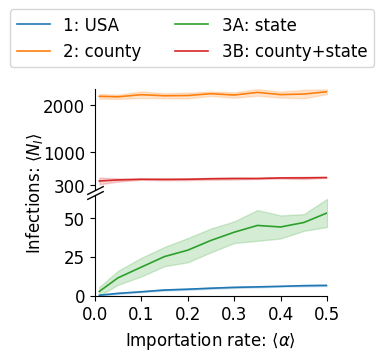

In [538]:
export_file = False
filename = 'infections'+append

figsize = [3,3]
colormap = 'tab10'  #'jet'
n_lines = len(vals_policy)

labels = ['1: USA', '2: county', '3A: state', '3B: county+state']
markers = ['o','^','x','s']

#cmap = mpl.colormaps.get_cmap(colormap).copy()
#cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, n_lines)))  # Set number of colors
cmap = mpl.colormaps.get_cmap(colormap)  #mpl.colormaps.get_cmap(obj)

# Set the figure size and adjust layout
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize)

# Update default font size and line width
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1.2})

# Plot
for hh in range(n_lines):
    
    axs[0].plot(vals_noise, avfinal_NI[:,hh], color=cmap(hh),
                label=labels[hh])#, marker=markers[hh])
    axs[0].fill_between(vals_noise, avfinal_NI[:,hh] + varfinal_NI[:,hh], 
                        avfinal_NI[:,hh] - varfinal_NI[:,hh], color=cmap(hh), alpha=0.2)
    axs[1].plot(vals_noise, avfinal_NI[:,hh], color=cmap(hh),
                label=labels[hh])#, marker=markers[hh])
    axs[1].fill_between(vals_noise, avfinal_NI[:,hh] + varfinal_NI[:,hh], 
                        avfinal_NI[:,hh] - varfinal_NI[:,hh], color=cmap(hh), alpha=0.2)

#axs[0].set_xlabel('Importations: '+r'$\langle \delta \rangle$')
#axs[1].set_xlabel('Importation rate: '+r'$\langle \delta \rangle$')
#axs[1].set_ylabel('Infections\nper unit time: ' + r'$\langle N_I \rangle/t$', labelpad=10 )
axs[0].legend(loc='center left', bbox_to_anchor=(-0.4,1.5), ncol=2)

axs[0].set_ylim(200, 2350)  # outliers only
axs[1].set_ylim(0, 65)  # most of the data
axs[0].set_xlim(0,0.5)  # most of the data
axs[1].set_xlim(0,0.5)  # most of the data

# hide the spines between ax and ax2
axs[0].spines.bottom.set_visible(False)
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)

#axs[0].xaxis.tick_top()
axs[0].set_xticks([])
axs[0].set_yticks([300,1000,2000])
axs[0].tick_params(labeltop=False)  # don't put tick labels at the top
axs[1].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
#axs[1].set_xticks([])
#axs[2].xaxis.tick_bottom()


d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
#axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
#axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
axs[0].plot([0], [0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0], [1], transform=axs[1].transAxes, **kwargs)

# Figure axes labels
ax = fig.add_subplot(111, frame_on=False)  # frame_on=False turns off the visible frame
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)  # Hide ticks and labels

ax.set_xlabel('Importation rate: '+r'$\langle \alpha \rangle$')
ax.set_ylabel('Infections: ' + r'$\langle N_I \rangle$', labelpad=10 )

plt.subplots_adjust(top=0.8, wspace=0.4, hspace=0.05)   # For top bar
    
if export_file:
    plt.savefig(fname='%s/%s.pdf'%(outputfolder,filename), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

Plot people locked down.

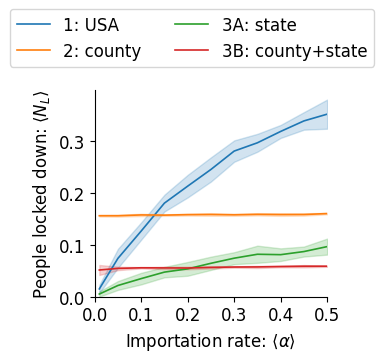

In [13]:
export_file = False
filename = 'lock'+append

figsize = [3,3]
colormap = 'tab10'  #'jet'
n_lines = len(vals_policy)

labels = ['1: USA', '2: county', '3A: state', '3B: county+state']
markers = ['o','^','x','s']

#cmap = mpl.colormaps.get_cmap(colormap).copy()
#cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, n_lines)))  # Set number of colors
cmap = mpl.colormaps.get_cmap(colormap)  #mpl.colormaps.get_cmap(obj)

# Set the figure size and adjust layout
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)

# Update default font size and line width
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1.2})

# Plot
for hh in range(n_lines):
    
    axs.plot(vals_noise, avfinal_cost[:,hh]/Ntots[0], color=cmap(hh),
                label=labels[hh])#, marker=markers[hh])
    axs.fill_between(vals_noise, (avfinal_cost[:,hh] + varfinal_cost[:,hh])/Ntots[0], 
                        (avfinal_cost[:,hh] - varfinal_cost[:,hh])/Ntots[0], color=cmap(hh), alpha=0.2)

axs.spines.top.set_visible(False)
axs.spines.right.set_visible(False)

axs.set_xlabel('Importation rate: '+r'$\langle \alpha \rangle$')
axs.set_ylabel('People locked down: ' + r'$\langle N_{L} \rangle$')
axs.legend(loc='center left', bbox_to_anchor=(-0.4,1.25), ncol=2)

axs.set_ylim(bottom=0)
axs.set_xlim(0,0.5)

axs.set_xticks([0,0.1,0.2,0.3,0.4,0.5])

plt.subplots_adjust(top=0.8, wspace=0.4, hspace=0.05)   # For top bar
    
if export_file:
    plt.savefig(fname='%s/%s.pdf'%(outputfolder,filename), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

### 3B state best

Run the following cell to import data files for the given simulation parameters.

In [14]:
# Import
params_import = params_default.copy()
params_import['Nt'] = 1000
params_import['beta'] = 2
params_import['sspread'] = 2
params_import['GtoRthreshold'] = 10     # 5 // 10 // 20 // 20
params_import['reductionLocal'] = 2.2     # 5 // 2  // 5  // 4
params_import['reductionTravel'] = 10    # 5 // 10 // 5 // 10

iters_import = 20

vals_noise = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
vals_policy = ['1scale','1scale','1scale','2scales']
vals_mpol1 = np.array([4,1,2,1])
vals_mpol2 = np.array([4,4,4,2])

final_cost = np.zeros((iters_import, len(vals_noise), len(vals_policy)))
final_NI = np.zeros((iters_import, len(vals_noise), len(vals_policy)))
avfinal_cost = np.zeros((len(vals_noise), len(vals_policy)))
avfinal_NI = np.zeros((len(vals_noise), len(vals_policy)))

import_data = True
filename = 'cost'
append = '_beta%g_ss%g_hGtoR%i_rL%g_rT%g_mpolX_Nt%i'%(params_import['beta'], params_import['sspread'],
    params_import['GtoRthreshold'], params_import['reductionLocal'], params_import['reductionTravel'],
    params_import['Nt'])
    
if import_data:
    
    for i in range(iters_import):

        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'NI_',filename,append,i)
        final_NI[i] = np.loadtxt(fname, comments='#')
        
        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'cost_',filename,append,i)
        final_cost[i] = np.loadtxt(fname, comments='#')

    avfinal_cost = np.sum(final_cost, axis=0)/iters_import
    avfinal_NI = np.sum(final_NI, axis=0)/iters_import

    varfinal_cost = np.sqrt(np.sum((final_cost-avfinal_cost)**2, axis=0)/iters_import)
    varfinal_NI = np.sqrt(np.sum((final_NI-avfinal_NI)**2, axis=0)/iters_import)




Plot infections.

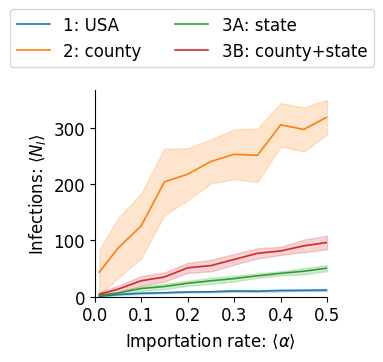

In [545]:
export_file = False
filename = 'infections'+append

figsize = [3,3]
colormap = 'tab10'  #'jet'
n_lines = len(vals_policy)

labels = ['1: USA', '2: county', '3A: state', '3B: county+state']
markers = ['o','^','x','s']

#cmap = mpl.colormaps.get_cmap(colormap).copy()
#cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, n_lines)))  # Set number of colors
cmap = mpl.colormaps.get_cmap(colormap)  #mpl.colormaps.get_cmap(obj)

# Set the figure size and adjust layout
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)

# Update default font size and line width
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1.2})

# Plot
for hh in range(n_lines):
    axs.plot(vals_noise, avfinal_NI[:,hh], color=cmap(hh),
                label=labels[hh])#, marker=markers[hh])
    axs.fill_between(vals_noise, avfinal_NI[:,hh] + varfinal_NI[:,hh], 
                        avfinal_NI[:,hh] - varfinal_NI[:,hh], color=cmap(hh), alpha=0.2)

axs.legend(loc='center left', bbox_to_anchor=(-0.4,1.25), ncol=2)

axs.spines.top.set_visible(False)
axs.spines.right.set_visible(False)

axs.set_xlabel('Importation rate: '+r'$\langle \alpha \rangle$')
axs.set_ylabel('Infections: ' + r'$\langle N_{I} \rangle$')

axs.set_xlim(0,0.5)
axs.set_ylim(bottom=0)  # most of the data
axs.set_xticks([0,0.1,0.2,0.3,0.4,0.5])

plt.subplots_adjust(top=0.8, wspace=0.4, hspace=0.05)   # For top bar
    
if export_file:
    plt.savefig(fname='%s/%s.pdf'%(outputfolder,filename), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

Plot people locked down.

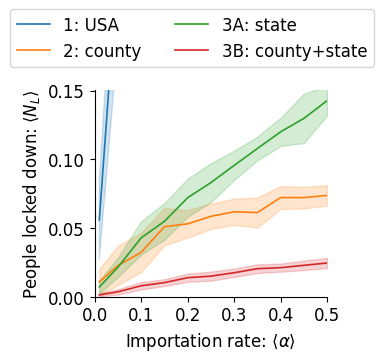

In [17]:
export_file = False
filename = 'lock'+append

figsize = [3,3]
colormap = 'tab10'  #'jet'
n_lines = len(vals_policy)

labels = ['1: USA', '2: county', '3A: state', '3B: county+state']
markers = ['o','^','x','s']

#cmap = mpl.colormaps.get_cmap(colormap).copy()
#cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, n_lines)))  # Set number of colors
cmap = mpl.colormaps.get_cmap(colormap)  #mpl.colormaps.get_cmap(obj)

# Set the figure size and adjust layout
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)

# Update default font size and line width
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1.2})

# Plot
for hh in range(n_lines):
    axs.plot(vals_noise, avfinal_cost[:,hh]/Ntots[0], color=cmap(hh),
                label=labels[hh])#, marker=markers[hh])
    axs.fill_between(vals_noise, (avfinal_cost[:,hh] + varfinal_cost[:,hh])/Ntots[0], 
                        (avfinal_cost[:,hh] - varfinal_cost[:,hh])/Ntots[0], color=cmap(hh), alpha=0.2)

axs.legend(loc='center left', bbox_to_anchor=(-0.4,1.25), ncol=2)

axs.set_ylim(bottom=0,top=0.5*10**8/Ntots[0])
axs.set_xlim(0,0.5)

# hide the spines between ax and ax2
axs.spines.top.set_visible(False)
axs.spines.right.set_visible(False)

axs.set_xticks([0,0.1,0.2,0.3,0.4,0.5])

axs.set_xlabel('Importation rate: '+r'$\langle \alpha \rangle$')
axs.set_ylabel('People locked down: ' + r'$\langle N_{L} \rangle$')

plt.subplots_adjust(top=0.8, wspace=0.4, hspace=0.05)   # For top bar
    
if export_file:
    plt.savefig(fname='%s/%s.pdf'%(outputfolder,filename), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

### 2 state best

Run the following cell to import data files for the given simulation parameters.

In [18]:
# Import
params_import = params_default.copy()
params_import['Nt'] = 1000
params_import['beta'] = 2
params_import['sspread'] = 2
params_import['GtoRthreshold'] = 5     # 5 // 10 // 20 // 20
params_import['reductionLocal'] = 5     # 5 // 2  // 5  // 4
params_import['reductionTravel'] = 5    # 5 // 10 // 5 // 10

iters_import = 10

vals_noise = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
vals_policy = ['1scale','1scale','1scale','2scales']
vals_mpol1 = np.array([4,1,2,1])
vals_mpol2 = np.array([4,4,4,2])

final_cost = np.zeros((iters_import, len(vals_noise), len(vals_policy)))
final_NI = np.zeros((iters_import, len(vals_noise), len(vals_policy)))
avfinal_cost = np.zeros((len(vals_noise), len(vals_policy)))
avfinal_NI = np.zeros((len(vals_noise), len(vals_policy)))

import_data = True
filename = 'cost'
append = '_beta%g_ss%g_hGtoR%i_rL%g_rT%g_mpolX_Nt%i'%(params_import['beta'], params_import['sspread'],
    params_import['GtoRthreshold'], params_import['reductionLocal'], params_import['reductionTravel'],
    params_import['Nt'])
    
if import_data:
    
    for i in range(iters_import):

        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'NI_',filename,append,i)
        final_NI[i] = np.loadtxt(fname, comments='#')
        
        fname = '%s/%s%s%s_iter%i.txt'%(outputfolder_data,'cost_',filename,append,i)
        final_cost[i] = np.loadtxt(fname, comments='#')

    avfinal_cost = np.sum(final_cost, axis=0)/iters_import
    avfinal_NI = np.sum(final_NI, axis=0)/iters_import

    varfinal_cost = np.sqrt(np.sum((final_cost-avfinal_cost)**2, axis=0)/iters_import)
    varfinal_NI = np.sqrt(np.sum((final_NI-avfinal_NI)**2, axis=0)/iters_import)


Plot infections.

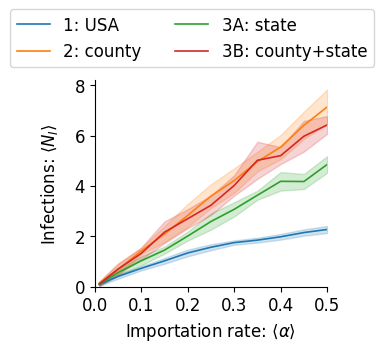

In [548]:
export_file = False
filename = 'infections'+append

figsize = [3,3]
colormap = 'tab10'  #'jet'
n_lines = len(vals_policy)

labels = ['1: USA', '2: county', '3A: state', '3B: county+state']
markers = ['o','^','x','s']

#cmap = mpl.colormaps.get_cmap(colormap).copy()
#cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, n_lines)))  # Set number of colors
cmap = mpl.colormaps.get_cmap(colormap)  #mpl.colormaps.get_cmap(obj)

# Set the figure size and adjust layout
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)

# Update default font size and line width
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1.2})

# Plot
for hh in range(n_lines):
    axs.plot(vals_noise, avfinal_NI[:,hh], color=cmap(hh),
                label=labels[hh])#, marker=markers[hh])
    axs.fill_between(vals_noise, avfinal_NI[:,hh] + varfinal_NI[:,hh], 
                        avfinal_NI[:,hh] - varfinal_NI[:,hh], color=cmap(hh), alpha=0.2)

axs.legend(loc='center left', bbox_to_anchor=(-0.4,1.2), ncol=2)

axs.set_ylim(bottom=0)  # most of the data
axs.set_xlim(0,0.5)  # most of the data

# hide the spines between ax and ax2
axs.spines.top.set_visible(False)
axs.spines.right.set_visible(False)

axs.set_xticks([0,0.1,0.2,0.3,0.4,0.5])

axs.set_xlabel('Importation rate: '+r'$\langle \alpha \rangle$')
axs.set_ylabel('Infections: ' + r'$\langle N_I \rangle$', labelpad=10 )


plt.subplots_adjust(top=0.8, wspace=0.4, hspace=0.05)   # For top bar
    
if export_file:
    plt.savefig(fname='%s/%s.pdf'%(outputfolder,filename), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

Plot people locked down.

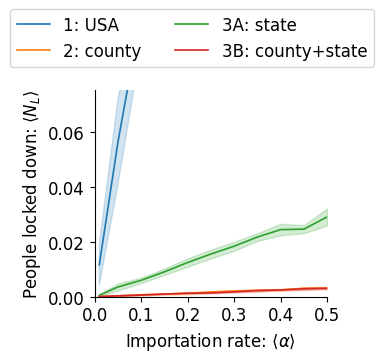

In [21]:
export_file = False
filename = 'lock'+append

figsize = [3,3]
colormap = 'tab10'  #'jet'
n_lines = len(vals_policy)

labels = ['1: USA', '2: county', '3A: state', '3B: county+state']
markers = ['o','^','x','s']

#cmap = mpl.colormaps.get_cmap(colormap).copy()
#cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, n_lines)))  # Set number of colors
cmap = mpl.colormaps.get_cmap(colormap)  #mpl.colormaps.get_cmap(obj)

# Set the figure size and adjust layout
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize)

# Update default font size and line width
plt.rcParams.update({'font.size': 12, 'lines.linewidth': 1.2})

# Plot
for hh in range(n_lines):
    axs.plot(vals_noise, avfinal_cost[:,hh]/Ntots[0], color=cmap(hh),
                label=labels[hh])#, marker=markers[hh])
    axs.fill_between(vals_noise, (avfinal_cost[:,hh] + varfinal_cost[:,hh])/Ntots[0], 
                        (avfinal_cost[:,hh] - varfinal_cost[:,hh])/Ntots[0], color=cmap(hh), alpha=0.2)

axs.legend(loc='center left', bbox_to_anchor=(-0.4,1.25), ncol=2)

axs.set_ylim(bottom=0,top=0.25*10**8/Ntots[0])  # most of the data
axs.set_xlim(0,0.5)  # most of the data

# hide the spines between ax and ax2
axs.spines.top.set_visible(False)
axs.spines.right.set_visible(False)

axs.set_xticks([0,0.1,0.2,0.3,0.4,0.5])

axs.set_xlabel('Importation rate: '+r'$\langle \alpha \rangle$')
axs.set_ylabel('People locked down: ' + r'$\langle N_{L} \rangle$')

plt.subplots_adjust(top=0.8, wspace=0.4, hspace=0.05)   # For top bar
    
if export_file:
    plt.savefig(fname='%s/%s.pdf'%(outputfolder,filename), format='pdf', bbox_inches='tight')

# Show the plot
plt.show()